# Analysis

## Fraud Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
import datetime
import matplotlib.pyplot as plt

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/15 16:59:21 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.29.56.17 instead (on interface eth0)
22/10/15 16:59:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/15 16:59:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/15 16:59:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Consumer Fraud

In [2]:
# Read in fraud data, check for nulls, and make all probabilites into double type for analysis

consumerfrauddf = spark.read.option("header","True").csv("../data/tables/consumer_fraud_probability.csv")
print(consumerfrauddf.count())
consumerfrauddf = consumerfrauddf.dropna("any")
print(consumerfrauddf.count())
consumerfrauddf = consumerfrauddf.withColumn("fraud_probability", col("fraud_probability").cast('double'))
consumerfrauddf.limit(5)

34864
34864


user_id,order_datetime,fraud_probability
6228,2021-12-19,97.6298077657765
21419,2021-12-10,99.24738020302328
5606,2021-10-17,84.05825045251777
3101,2021-04-17,91.42192091901347
22239,2021-10-19,94.70342477508035


No null values

In [3]:
# Check if consumer ids valid

testdf = consumerfrauddf.filter(consumerfrauddf["user_id"] > 0)
testdf = testdf.filter(consumerfrauddf["user_id"] <= 24081)
print(testdf.count())

34864


All consumer ids valid 

In [4]:
# Check if datetimes valid

start_date = datetime.datetime(2021, 2, 28) 
end_date = datetime.datetime(2022, 2, 28)
testdf = consumerfrauddf.filter(consumerfrauddf["order_datetime"] >= start_date)
testdf = testdf.filter(consumerfrauddf["order_datetime"] <= end_date)
testdf.count()

34864

All datetimes valid

In [5]:
# Check for repeats

print(consumerfrauddf.count())
print(consumerfrauddf.distinct().count())

34864
34765


99 repeat values exist

In [6]:
# Print repeats

print(consumerfrauddf.groupBy("user_id","order_datetime").count().orderBy(desc("count")).limit(5))

+-------+--------------+-----+
|user_id|order_datetime|count|
+-------+--------------+-----+
|   3524|    2021-10-04|    2|
|  22932|    2021-11-29|    2|
|  23700|    2021-08-26|    2|
|  11488|    2021-09-30|    2|
|  11073|    2021-10-16|    2|
+-------+--------------+-----+



In [7]:
# See if repeats are the same

testdf = consumerfrauddf.filter(consumerfrauddf["user_id"] == 23700)
testdf

user_id,order_datetime,fraud_probability
23700,2021-08-26,75.16555491373008
23700,2021-08-26,75.16555491373008


They are indeed duplicates with the same fraud probability so will be removed

In [8]:
# Remove duplicates

consumerfrauddf = consumerfrauddf.distinct()

+----------------------+----------------------+----------------------+
|min(fraud_probability)|max(fraud_probability)|avg(fraud_probability)|
+----------------------+----------------------+----------------------+
|     8.287143531552802|     99.24738020302328|    14.945849912240222|
+----------------------+----------------------+----------------------+



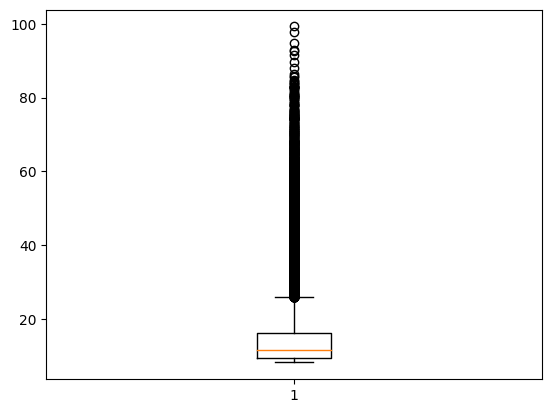

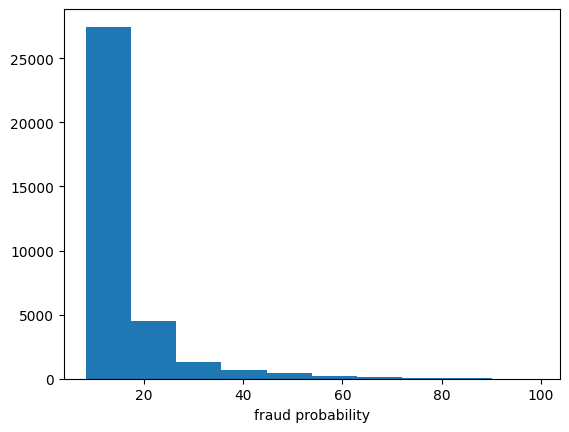

In [9]:
# Print distributions of fraud probabilities

df = consumerfrauddf.toPandas()

print(consumerfrauddf.agg(min("fraud_probability"), max("fraud_probability"), mean("fraud_probability")))

plt.boxplot(df["fraud_probability"])
plt.show()

plt.hist(df["fraud_probability"])
plt.xlabel("fraud probability")
plt.show() 

Most consumer fraud probabilities are towards lower end of spectrum

+--------------------+--------------------+--------------------+
|min(fraudulent_days)|max(fraudulent_days)|avg(fraudulent_days)|
+--------------------+--------------------+--------------------+
|                   1|                   6|   1.727195945945946|
+--------------------+--------------------+--------------------+

+---------------+---------+
|fraudulent_days|frequency|
+---------------+---------+
|              1|     9355|
|              2|     7520|
|              3|     2699|
|              4|      502|
|              5|       47|
|              6|        5|
+---------------+---------+



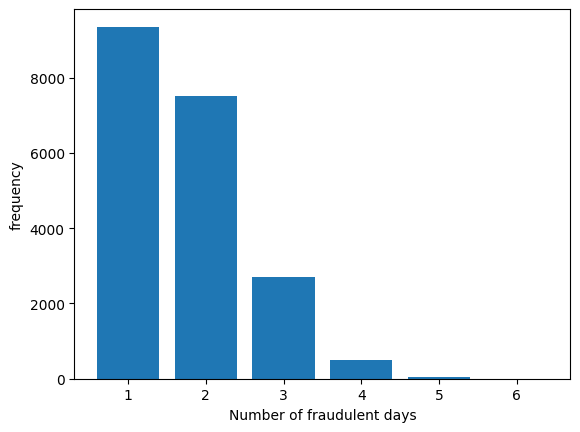

In [10]:
# See and plot the number of times any user commits fraud

testdf = consumerfrauddf.groupBy("user_id").agg(count("user_id").alias("fraudulent_days"))
print(testdf.agg(min("fraudulent_days"), max("fraudulent_days"), mean("fraudulent_days")))
testdf = testdf.groupBy("fraudulent_days").agg(count("fraudulent_days").alias("frequency")).orderBy("fraudulent_days")
print(testdf)

df = testdf.toPandas()
plt.bar(df["fraudulent_days"],df["frequency"])
plt.xlabel("Number of fraudulent days")
plt.ylabel("frequency")
plt.show() 

First table shows that the minimum number of times a user had a fraudulent transaction day was 1 and the maximum number of times was 6 with an average of 1.7 fraudulent days for any given user <br>
Table 2 and the bar chart show the frequency

In [11]:
consumerfrauddf.limit(5)

user_id,order_datetime,fraud_probability
3753,2022-02-16,48.85325253622543
9646,2021-09-23,47.83931206340956
243,2021-09-02,50.88971939168309
3907,2021-10-07,38.58123424858352
14864,2021-11-29,27.072321329372105


In [12]:
# Save final consumer fraud dataframe without duplicate entries

consumerfrauddf.write.mode("overwrite").parquet('../data/curated/consumerfrauddf.parquet')

### Merchant Fraud

In [13]:
# Read in fraud data, check for nulls, and make all probabilites into double type for analysis

merchantfrauddf = spark.read.option("header","True").csv("../data/tables/merchant_fraud_probability.csv")
print(merchantfrauddf.count())
merchantfrauddf = merchantfrauddf.dropna("any")
print(merchantfrauddf.count())
merchantfrauddf = merchantfrauddf.withColumn("fraud_probability", col("fraud_probability").cast('double'))
merchantfrauddf.limit(5)

114
114


merchant_abn,order_datetime,fraud_probability
19492220327,2021-11-28,44.403658647495355
31334588839,2021-10-02,42.75530083865367
19492220327,2021-12-22,38.867790051131095
82999039227,2021-12-19,94.1347004808891
90918180829,2021-09-02,43.32551731714902


No null values

In [14]:
# Invalid merchant abns will be removed when joining

In [15]:
# Check all datetimes valid

start_date = datetime.datetime(2021, 2, 28) 
end_date = datetime.datetime(2022, 2, 28)
testdf = merchantfrauddf.filter(merchantfrauddf["order_datetime"] >= start_date)
testdf = testdf.filter(merchantfrauddf["order_datetime"] <= end_date)
testdf.count()

114

All datetimes valid

+----------------------+----------------------+----------------------+
|min(fraud_probability)|max(fraud_probability)|avg(fraud_probability)|
+----------------------+----------------------+----------------------+
|     18.21089142894488|      94.1347004808891|    40.419334695018094|
+----------------------+----------------------+----------------------+



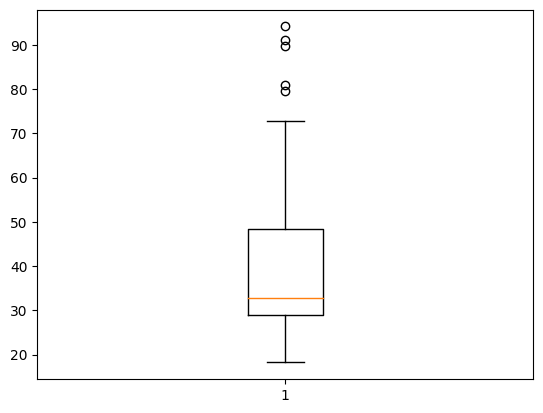

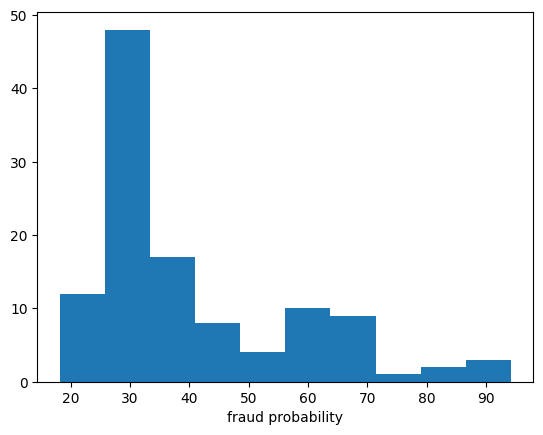

In [16]:
# Print distributions of fraud probabilities

df = merchantfrauddf.toPandas()

print(merchantfrauddf.agg(min("fraud_probability"), max("fraud_probability"), mean("fraud_probability")))

plt.boxplot(df["fraud_probability"])
plt.show()

plt.hist(df["fraud_probability"])
plt.xlabel("fraud probability")
plt.show() 

Merchant fraud probabilities are more evenly spread out then user ones

+--------------------+--------------------+--------------------+
|min(fraudulent_days)|max(fraudulent_days)|avg(fraudulent_days)|
+--------------------+--------------------+--------------------+
|                   1|                  12|  1.8688524590163935|
+--------------------+--------------------+--------------------+

+---------------+---------+
|fraudulent_days|frequency|
+---------------+---------+
|              1|       44|
|              2|        5|
|              3|        6|
|              4|        1|
|              5|        1|
|              6|        1|
|              7|        1|
|              8|        1|
|             12|        1|
+---------------+---------+



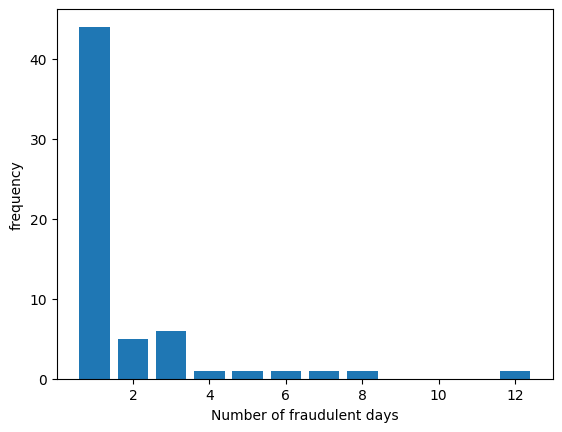

In [17]:
# See and plot the number of times any merchant commits fraud

testdf = merchantfrauddf.groupBy("merchant_abn").agg(count("merchant_abn").alias("fraudulent_days"))
print(testdf.agg(min("fraudulent_days"), max("fraudulent_days"), mean("fraudulent_days")))
testdf = testdf.groupBy("fraudulent_days").agg(count("fraudulent_days").alias("frequency")).orderBy("fraudulent_days")
print(testdf)

df = testdf.toPandas()
plt.bar(df["fraudulent_days"],df["frequency"])
plt.xlabel("Number of fraudulent days")
plt.ylabel("frequency")
plt.show() 

Most merchants had a low number of fraudulent days

In [18]:
merchantfrauddf.limit(5)

merchant_abn,order_datetime,fraud_probability
19492220327,2021-11-28,44.403658647495355
31334588839,2021-10-02,42.75530083865367
19492220327,2021-12-22,38.867790051131095
82999039227,2021-12-19,94.1347004808891
90918180829,2021-09-02,43.32551731714902


In [19]:
# Save final merchant fraud dataframe with double type probabilities

merchantfrauddf.write.mode("overwrite").parquet('../data/curated/merchantfrauddf.parquet')